In [30]:
#import PIL.Image as pilimg
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

drive.mount('/content/gdriv')

Drive already mounted at /content/gdriv; to attempt to forcibly remount, call drive.mount("/content/gdriv", force_remount=True).


In [31]:
import os
good_path = "/content/gdriv/My Drive/Colab Notebooks/data/gear/train/good" 
good_image_list = os.listdir(good_path)
error_path = "/content/gdriv/My Drive/Colab Notebooks/data/gear/train/error"
error_image_list = os.listdir(error_path)

print(good_image_list)
print(error_image_list)

['NonDefect-2.bmp', 'NonDefect-4.bmp', 'NonDefect-1.bmp', 'NonDefect-3.bmp', 'NonDefect-5.bmp', 'NonDefect-0.bmp', 'NonDefect-9.bmp', 'NonDefect-8.bmp']
['Defect-16.bmp', 'Defect-14.bmp', 'Defect-13.bmp', 'Defect-12.bmp', 'Defect-11.bmp', 'Defect-10.bmp', 'Defect-1.bmp', 'Defect-0.bmp', 'Defect-9.bmp', 'Defect-8.bmp', 'Defect-7.bmp', 'Defect-6.bmp', 'Defect-55.bmp', 'Defect-56.bmp', 'Defect-54.bmp', 'Defect-53.bmp', 'Defect-52.bmp', 'Defect-51.bmp', 'Defect-50.bmp', 'Defect-5.bmp', 'Defect-49.bmp', 'Defect-4.bmp', 'Defect-3.bmp', 'Defect-27.bmp', 'Defect-25.bmp', 'Defect-26.bmp', 'Defect-24.bmp', 'Defect-23.bmp', 'Defect-22.bmp', 'Defect-21.bmp', 'Defect-20.bmp', 'Defect-2.bmp', 'Defect-19.bmp', 'Defect-18.bmp', 'Defect-17.bmp', 'Defect-15.bmp']


In [32]:
good = []
# good image 
for good_image_list_value in good_image_list:
  # Read image
  img = Image.open(good_path + '/' + good_image_list_value) 
  # Fetch image pixel data to numpy array
  good.append(np.array(img))

In [33]:
error = []
# good image 
for error_image_list_value in error_image_list:
  # Read image
  img = Image.open(error_path + '/' + error_image_list_value) 
  # Fetch image pixel data to numpy array
  error.append(np.array(img))

In [34]:
# 학습 데이터 전처리 모듈

class ImageLoader(Dataset):
    
    def read_data_set(self):
        all_img_files = []      
        all_labels = []
        class_names = os.walk(self.data_set_path).__next__()[1]
        print(class_names)

        for index, class_name in enumerate(class_names):
            
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                
                if img is not None:
                  all_img_files.append(img_file)
                  all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        
        image = Image.open(self.image_files_path[index])
        #image = Image.convert("RGB")

        if self.transforms is not None:
          image = self.transforms(image)

        return {'image': image, 'label': self.labels[index]}

    def __len__(self):
        return self.length

In [35]:
TransformsTrain = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])
   
TransformsTest = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])

TrainDataSet = ImageLoader(data_set_path='/content/gdriv/My Drive/Colab Notebooks/data/gear/train', 
                                              transforms=TransformsTrain)

TrainLoader = DataLoader(TrainDataSet, batch_size=8, shuffle=True)
TestDataSet = ImageLoader(data_set_path='/content/gdriv/My Drive/Colab Notebooks/data/gear/test', 
                                             transforms=TransformsTest)

TestLoader = DataLoader(TestDataSet, batch_size=8, shuffle=True)

['error', 'good']
['error', 'good']


In [36]:
# CNN 네트워크 구조 정의

class cnn(nn.Module):
  
  def __init__(self, input_dim, hid_dim, out_dim):
    super(cnn, self).__init__()
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.out_dim = out_dim
    self.conv_block1 = self.conv_block(input_dim, hid_dim)
    self.conv_block2 = self.conv_block(hid_dim, hid_dim*2)
    self.conv_block3 = self.conv_block(hid_dim*2, hid_dim*4)
    self.conv_block4 = self.conv_block(hid_dim*4, hid_dim*8)
    self.final_block = self.avg_block(hid_dim*8, out_dim)

  def forward(self, x):
    out = self.conv_block1(x)
    out = self.conv_block2(out)
    out = self.conv_block3(out)
    out = self.conv_block4(out)
    out = self.final_block(out)
    out = out.view(-1, self.out_dim)
    return out

  def conv_block(self, in_size, out_size):
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_size),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  def avg_block(self, in_size, out_size):
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_size),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1))
    )

In [37]:
model = cnn(3,8,2).cuda()

In [38]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
losses = []
for e in range(1500):

  for i_batch, item in enumerate(TrainLoader):      
    images = item['image'].cuda()
    labels = item['label'].cuda()

    outputs = model(images)        
    L = loss(outputs, labels)
    losses.append(L.item())
    # Backward and optimize
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
  if (e+1)%100 == 0:
    print('[Epoch: {}/{}], [Loss: {:.4f}]'.format(e + 1, 1500, L.item()))

[Epoch: 100/1500], [Loss: 0.2935]
[Epoch: 200/1500], [Loss: 0.1411]
[Epoch: 300/1500], [Loss: 0.1528]
[Epoch: 400/1500], [Loss: 0.1296]
[Epoch: 500/1500], [Loss: 0.0421]
[Epoch: 600/1500], [Loss: 0.0283]
[Epoch: 700/1500], [Loss: 0.0575]
[Epoch: 800/1500], [Loss: 0.0668]
[Epoch: 900/1500], [Loss: 0.0637]
[Epoch: 1000/1500], [Loss: 0.0084]
[Epoch: 1100/1500], [Loss: 0.0260]
[Epoch: 1200/1500], [Loss: 0.0053]
[Epoch: 1300/1500], [Loss: 0.0046]
[Epoch: 1400/1500], [Loss: 0.0030]
[Epoch: 1500/1500], [Loss: 0.0172]


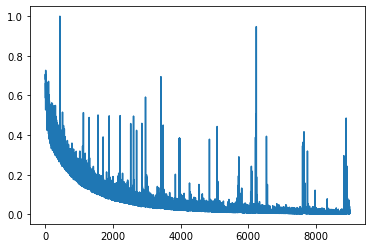

In [54]:
plt.plot(losses)

In [47]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for item in TestLoader:
      images = item['image'].cuda()
      labels = item['label'].cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += len(labels)
      correct += (predicted == labels).sum().item()

print('[Test Accuracy: {:2f}]'.format(100 * correct / total))

[Test Accuracy: 95.652174]
